In [119]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsforecast import StatsForecast
os.environ['NIXTLA_ID_AS_COL'] = '1'

In [103]:
Data = pd.read_excel("../Data/Case Study_2024.xlsx",sheet_name='Raw Data',header=1)

In [104]:
Data['Month_Year'] = Data['Month'].astype(str)+"-"+Data['Year'].astype(str)
Data['Actual_Price'] = 250
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
Data['Month'] = Data['Month'].map(month_mapping)
Data['Date'] = pd.to_datetime(Data[['Year', 'Month']].assign(DAY=1))
Data['Discount'] = ((Data['Unit Sales'] * Data['Actual_Price']) - Data['Revenue $']) / Data['Unit Sales']
Data['Discount_Flag'] = (Data['Discount']>0).astype(int)

In [105]:
Data[['City','Discount_Flag','Date','Unit Sales']]

,City,Discount_Flag,Date,Unit Sales
0,1,0,2015-01-01,10639
1,2,0,2015-01-01,24232
2,3,0,2015-01-01,11861
3,4,0,2015-01-01,51507
4,1,0,2015-02-01,15256
...,...,...,...,...
427,4,0,2023-11-01,70126
428,1,0,2023-12-01,29061
429,2,0,2023-12-01,76623
430,3,0,2023-12-01,18420


In [40]:
X_ts = Data[['City','Discount_Flag','Date','Unit Sales']]
X_ts.columns = ['unique_id','Discount_Flag','ds','y']
X_ts.loc['unique_id'] = X_ts.unique_id.astype(str)
X_ts.dropna(inplace=True)
X_ts.head()

/var/folders/4d/0kc0yx85313214x27mfl_cpw0000gn/T/ipykernel_91514/3989177893.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ts.loc['unique_id'] = X_ts.unique_id.astype(str)
/var/folders/4d/0kc0yx85313214x27mfl_cpw0000gn/T/ipykernel_91514/3989177893.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ts.dropna(inplace=True)


,unique_id,Discount_Flag,ds,y
0,1.0,0.0,2015-01-01,10639.0
1,2.0,0.0,2015-01-01,24232.0
2,3.0,0.0,2015-01-01,11861.0
3,4.0,0.0,2015-01-01,51507.0
4,1.0,0.0,2015-02-01,15256.0


In [47]:
train = X_ts[X_ts['ds']<'2023']
X_test = X_ts[X_ts['ds']>='2023']

# Forecasting

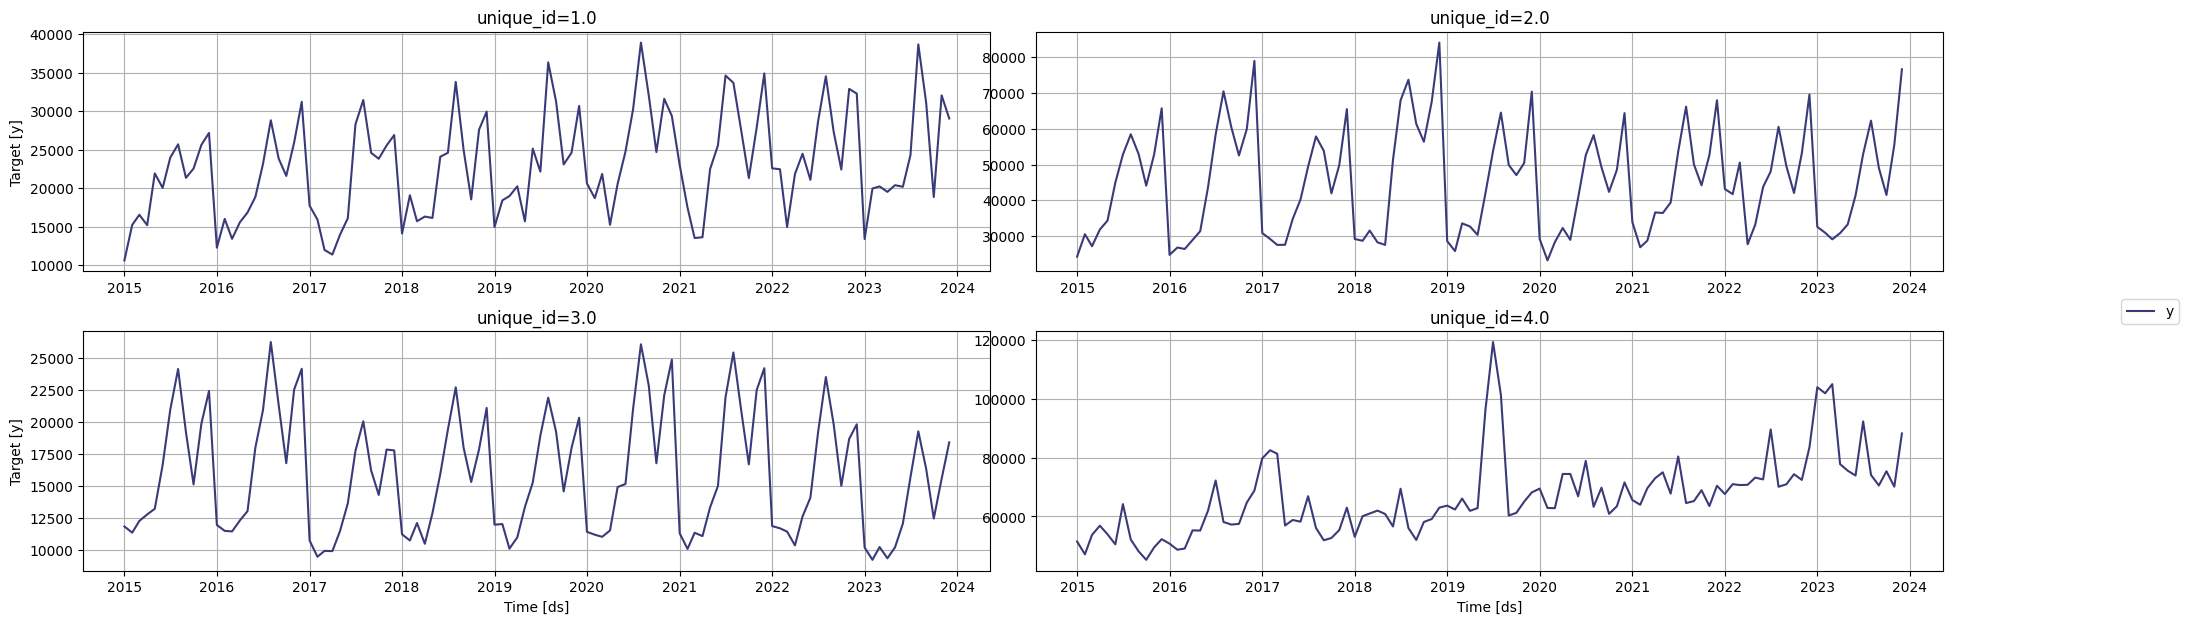

In [42]:
StatsForecast.plot(X_ts)

In [43]:
X_ts

,unique_id,Discount_Flag,ds,y
0,1.0,0.0,2015-01-01,10639.0
1,2.0,0.0,2015-01-01,24232.0
2,3.0,0.0,2015-01-01,11861.0
3,4.0,0.0,2015-01-01,51507.0
4,1.0,0.0,2015-02-01,15256.0
...,...,...,...,...
427,4.0,0.0,2023-11-01,70126.0
428,1.0,0.0,2023-12-01,29061.0
429,2.0,0.0,2023-12-01,76623.0
430,3.0,0.0,2023-12-01,18420.0


In [44]:
from statsforecast.models import AutoARIMA

In [45]:
# Create a list with the model and its instantiation parameters 
models = [AutoARIMA(season_length=12)]


In [46]:
sf = StatsForecast(
    models=models, 
    freq='M', 
    n_jobs=1,
)


In [120]:
horizon = 12
level = [95]

fcst = sf.forecast(df=train, h=horizon, X_df=X_test.drop(columns=['y']), level=level)
fcst.head()


,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
0,1.0,2022-12-31,20623.408203,13952.451172,27294.365234
1,1.0,2023-01-31,20894.074219,14031.845703,27756.302734
2,1.0,2023-02-28,16091.660156,9218.462891,22964.857422
3,1.0,2023-03-31,19776.845703,12903.009766,26650.679688
4,1.0,2023-04-30,22446.740234,15572.867188,29320.611328


/Users/vamshimugala/Desktop/polymerization-predictive-model/Polymerization/lib/python3.10/site-packages/statsforecast/core.py:1386: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


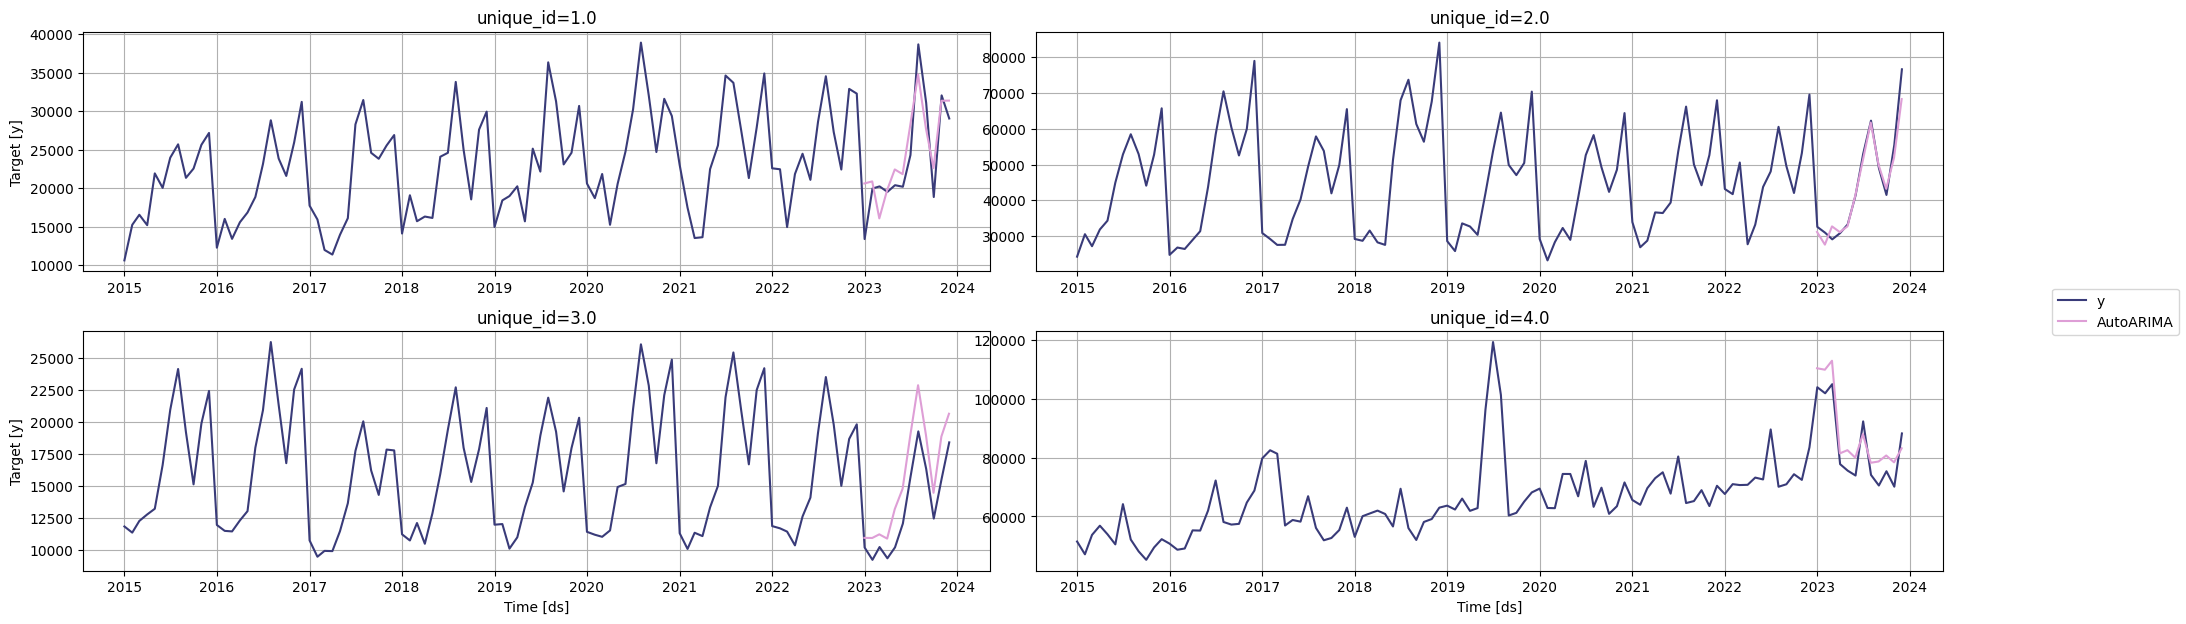

In [56]:
StatsForecast.plot(X_ts, fcst)

# Evaluating the model with exog

In [175]:
def calculate_metrics_with_thresholds(fcst, X_test, threshold=0.1):
    results = {}
    unique_ids = X_test['unique_id'].unique()
    descriptive_strings = []
    
    for uid in unique_ids:
        # Filter data for the specific unique_id
        fcst_filtered = fcst[fcst['unique_id'] == uid]
        X_test_filtered = X_test[X_test['unique_id'] == uid]
        
        # Align the indexes for accurate calculation
        y_true = X_test_filtered['y'].astype(float).reset_index(drop=True)
        y_pred = fcst_filtered['AutoARIMA'].astype(float).reset_index(drop=True)
        
        # Calculate MAE
        mae = abs(y_true - y_pred).mean()
        
        # Calculate SMAPE
        smape = 100 * (abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred)) / 2)).mean()
        
        # Calculate Under and Over Forecast Rates with threshold
        under_forecast_rate = ((y_true - y_pred) / y_true > threshold).mean()
        over_forecast_rate = ((y_pred - y_true) / y_true > threshold).mean()

        # Calculate R-squared
        ss_total = ((y_true - y_true.mean()) ** 2).sum()
        ss_residual = ((y_true - y_pred) ** 2).sum()
        r_squared = 1 - (ss_residual / ss_total)
        
        # Store results in a dictionary
        results[uid] = {
            'MAE': mae,
            'SMAPE': smape,
            'R-squared': r_squared,
            'Under Forecast Rate': under_forecast_rate,
            'Over Forecast Rate': over_forecast_rate
        }
        
        # Build a descriptive string
        descriptive_string = (f"For City={uid}: MAE is {mae:.2f}, SMAPE is {smape:.2f}%, R-squared is {r_squared:.2f}, "
                              f"Under Forecast Rate (>{threshold*100:.1f}% deviation) is {under_forecast_rate:.2%}, "
                              f"Over Forecast Rate (>{threshold*100:.1f}% deviation) is {over_forecast_rate:.2%}.")
        descriptive_strings.append(descriptive_string)
    
    return results, descriptive_strings

# Example usage with your dataframes
threshold = 0.1  # Example threshold of 10%
metrics_results, descriptions = calculate_metrics_with_thresholds(fcst, X_test, threshold)
for desc in descriptions:
    print(desc)



For City=1.0: MAE is 2836.28, SMAPE is 12.73%, R-squared is 0.76, Under Forecast Rate (>10.0% deviation) is 25.00%, Over Forecast Rate (>10.0% deviation) is 33.33%.
For City=2.0: MAE is 2160.81, SMAPE is 4.85%, R-squared is 0.95, Under Forecast Rate (>10.0% deviation) is 16.67%, Over Forecast Rate (>10.0% deviation) is 8.33%.
For City=3.0: MAE is 2306.89, SMAPE is 15.84%, R-squared is 0.49, Under Forecast Rate (>10.0% deviation) is 0.00%, Over Forecast Rate (>10.0% deviation) is 83.33%.
For City=4.0: MAE is 6191.61, SMAPE is 7.26%, R-squared is 0.75, Under Forecast Rate (>10.0% deviation) is 0.00%, Over Forecast Rate (>10.0% deviation) is 16.67%.


In [176]:
# Example usage with your dataframes
metrics_results, descriptions = calculate_metrics_with_thresholds(fcst_u, X_test)
for desc in descriptions:
    print(desc)

For City=1.0: MAE is 2836.28, SMAPE is 12.73%, R-squared is 0.76, Under Forecast Rate (>10.0% deviation) is 25.00%, Over Forecast Rate (>10.0% deviation) is 33.33%.
For City=2.0: MAE is 2183.06, SMAPE is 4.89%, R-squared is 0.95, Under Forecast Rate (>10.0% deviation) is 0.00%, Over Forecast Rate (>10.0% deviation) is 8.33%.
For City=3.0: MAE is 2680.66, SMAPE is 17.05%, R-squared is 0.22, Under Forecast Rate (>10.0% deviation) is 0.00%, Over Forecast Rate (>10.0% deviation) is 75.00%.
For City=4.0: MAE is 11539.22, SMAPE is 13.64%, R-squared is -0.50, Under Forecast Rate (>10.0% deviation) is 41.67%, Over Forecast Rate (>10.0% deviation) is 0.00%.


## No exogernous features

In [138]:
# univariate model 
fcst_u = sf.forecast(df=train,X_df=X_test.drop(columns=['y','Discount_Flag']), h=12)

/Users/vamshimugala/Desktop/polymerization-predictive-model/Polymerization/lib/python3.10/site-packages/statsforecast/arima.py:1612: UserWarning: xreg not required by this model, ignoring the provided regressors
  warnings.warn(
/Users/vamshimugala/Desktop/polymerization-predictive-model/Polymerization/lib/python3.10/site-packages/statsforecast/arima.py:1612: UserWarning: xreg not required by this model, ignoring the provided regressors
  warnings.warn(
/Users/vamshimugala/Desktop/polymerization-predictive-model/Polymerization/lib/python3.10/site-packages/statsforecast/arima.py:1612: UserWarning: xreg not required by this model, ignoring the provided regressors
  warnings.warn(
/Users/vamshimugala/Desktop/polymerization-predictive-model/Polymerization/lib/python3.10/site-packages/statsforecast/arima.py:1612: UserWarning: xreg not required by this model, ignoring the provided regressors
  warnings.warn(


In [140]:
fcst_u
abs(X_test['y'].astype(int).reset_index(drop=True) - fcst_u['AutoARIMA'].astype(int)).mean()

27287.979166666668

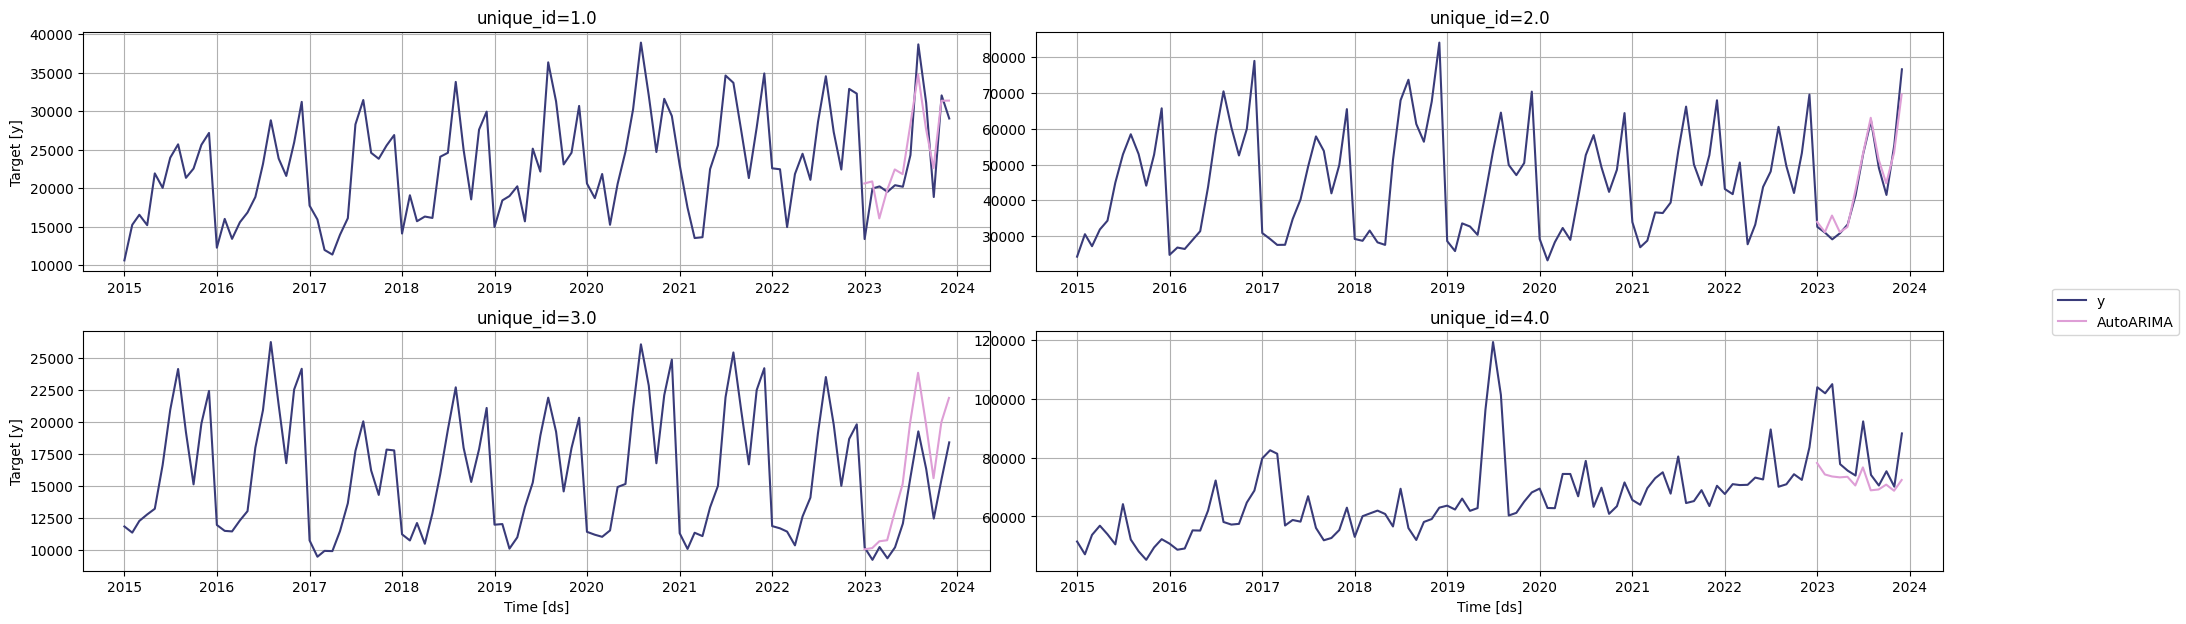

In [141]:
StatsForecast.plot(X_ts, fcst_u)

## Future data creation

In [58]:
# Define unique_ids and date range for 2024
unique_ids = [1, 2, 3, 4]
date_range = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS')

# Create a DataFrame for 2024 with the specified unique_ids and all Discount_Flag set to 0
data = []

for date in date_range:
    for unique_id in unique_ids:
        data.append({'unique_id': unique_id, 'Discount_Flag': 0.0, 'ds': date})

# Convert the list to a DataFrame
future_data = pd.DataFrame(data)

In [87]:
future_forecast = sf.forecast(X_df=future_data, h=12, level=[90])

/Users/vamshimugala/Desktop/polymerization-predictive-model/Polymerization/lib/python3.10/site-packages/statsforecast/core.py:467: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/Users/vamshimugala/Desktop/polymerization-predictive-model/Polymerization/lib/python3.10/site-packages/statsforecast/core.py:485: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


## Forecasts for 2024

/Users/vamshimugala/Desktop/polymerization-predictive-model/Polymerization/lib/python3.10/site-packages/statsforecast/core.py:1386: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


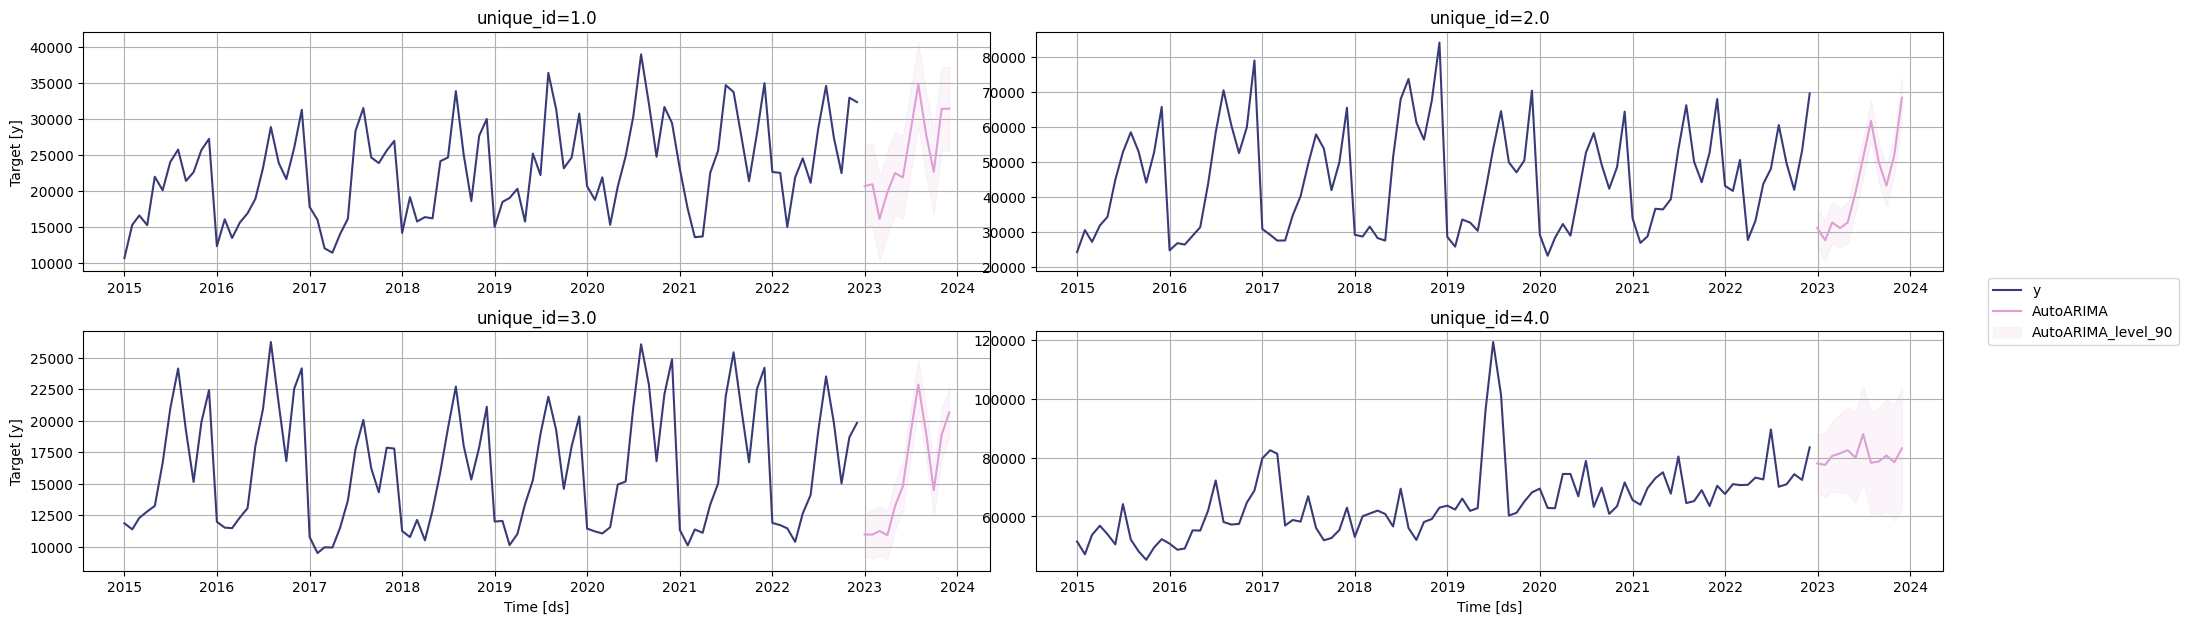

In [89]:
sf.plot(train,id_col='City', future_forecast, level=[90])

In [255]:
future_forecast.reset_index().groupby('unique_id')['AutoARIMA'].sum().reset_index().round().astype(int).rename(columns={'unique_id': 'City', 'AutoARIMA': 'Forecast'})

,City,Forecast
0,1,297742
1,2,522851
2,3,186947
3,4,967156


## Try basic models first

In [177]:
from statsforecast.models import (
    HoltWinters,
    HistoricAverage,
    SeasonalNaive
)

In [178]:
# Create a list of models and instantiation parameters
models = [
    HoltWinters(),
    SeasonalNaive(season_length=12),
    HistoricAverage(),
]

In [179]:
# Instantiate StatsForecast class as sf
sf = StatsForecast( 
    models=models,
    freq='M', 
    fallback_model = SeasonalNaive(season_length=12),
    n_jobs=-1,
)

In [186]:
Naive_forecasts_df = sf.forecast(df=train,X_df= X_test.drop(columns=['y','Discount_Flag']), h=horizon, level=[95])
Naive_forecasts_df.head()

,unique_id,ds,HoltWinters,HoltWinters-lo-95,HoltWinters-hi-95,SeasonalNaive,SeasonalNaive-lo-95,SeasonalNaive-hi-95,HistoricAverage,HistoricAverage-lo-95,HistoricAverage-hi-95
0,1.0,2022-12-31,22592.0,15474.249023,29709.75,22592.0,15474.249023,29709.75,22897.791016,10043.817383,35751.765625
1,1.0,2023-01-31,22468.0,15350.249023,29585.75,22468.0,15350.249023,29585.75,22897.791016,10043.817383,35751.765625
2,1.0,2023-02-28,14967.0,7849.249023,22084.75,14967.0,7849.249023,22084.75,22897.791016,10043.817383,35751.765625
3,1.0,2023-03-31,21848.0,14730.249023,28965.75,21848.0,14730.249023,28965.75,22897.791016,10043.817383,35751.765625
4,1.0,2023-04-30,24484.0,17366.250000,31601.75,24484.0,17366.250000,31601.75,22897.791016,10043.817383,35751.765625


In [188]:
def calculate_metrics_with_thresholds(fcst, X_test,algo_name, threshold=0.1):
    results = {}
    unique_ids = X_test['unique_id'].unique()
    descriptive_strings = []
    
    for uid in unique_ids:
        # Filter data for the specific unique_id
        fcst_filtered = fcst[fcst['unique_id'] == uid]
        X_test_filtered = X_test[X_test['unique_id'] == uid]
        
        # Align the indexes for accurate calculation
        y_true = X_test_filtered['y'].astype(float).reset_index(drop=True)
        y_pred = fcst_filtered[algo_name].astype(float).reset_index(drop=True)
        
        # Calculate MAE
        mae = abs(y_true - y_pred).mean()
        
        # Calculate SMAPE
        smape = 100 * (abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred)) / 2)).mean()
        
        # Calculate Under and Over Forecast Rates with threshold
        under_forecast_rate = ((y_true - y_pred) / y_true > threshold).mean()
        over_forecast_rate = ((y_pred - y_true) / y_true > threshold).mean()

        # Calculate R-squared
        ss_total = ((y_true - y_true.mean()) ** 2).sum()
        ss_residual = ((y_true - y_pred) ** 2).sum()
        r_squared = 1 - (ss_residual / ss_total)
        
        # Store results in a dictionary
        results[uid] = {
            'MAE': mae,
            'SMAPE': smape,
            'R-squared': r_squared,
            'Under Forecast Rate': under_forecast_rate,
            'Over Forecast Rate': over_forecast_rate
        }
        
        # Build a descriptive string
        descriptive_string = (f"For City={uid}: MAE is {mae:.2f}, SMAPE is {smape:.2f}%, R-squared is {r_squared:.2f}, "
                              f"Under Forecast Rate (>{threshold*100:.1f}% deviation) is {under_forecast_rate:.2%}, "
                              f"Over Forecast Rate (>{threshold*100:.1f}% deviation) is {over_forecast_rate:.2%}.")
        descriptive_strings.append(descriptive_string)
    
    return results, descriptive_strings

# Example usage with your dataframes
threshold = 0.1  # Example threshold of 10%
metrics_results, descriptions = calculate_metrics_with_thresholds(Naive_forecasts_df, X_test,'SeasonalNaive', threshold)
for desc in descriptions:
    print(desc)



For City=1.0: MAE is 3675.33, SMAPE is 16.45%, R-squared is 0.62, Under Forecast Rate (>10.0% deviation) is 25.00%, Over Forecast Rate (>10.0% deviation) is 58.33%.
For City=2.0: MAE is 5454.58, SMAPE is 13.07%, R-squared is 0.68, Under Forecast Rate (>10.0% deviation) is 8.33%, Over Forecast Rate (>10.0% deviation) is 25.00%.
For City=3.0: MAE is 2415.42, SMAPE is 16.59%, R-squared is 0.44, Under Forecast Rate (>10.0% deviation) is 0.00%, Over Forecast Rate (>10.0% deviation) is 91.67%.
For City=4.0: MAE is 10605.92, SMAPE is 12.56%, R-squared is -0.78, Under Forecast Rate (>10.0% deviation) is 25.00%, Over Forecast Rate (>10.0% deviation) is 0.00%.


In [189]:
# Example usage with your dataframes
threshold = 0.1  # Example threshold of 10%
metrics_results, descriptions = calculate_metrics_with_thresholds(Naive_forecasts_df, X_test,'HoltWinters', threshold)
for desc in descriptions:
    print(desc)

For City=1.0: MAE is 3675.33, SMAPE is 16.45%, R-squared is 0.62, Under Forecast Rate (>10.0% deviation) is 25.00%, Over Forecast Rate (>10.0% deviation) is 58.33%.
For City=2.0: MAE is 5454.58, SMAPE is 13.07%, R-squared is 0.68, Under Forecast Rate (>10.0% deviation) is 8.33%, Over Forecast Rate (>10.0% deviation) is 25.00%.
For City=3.0: MAE is 2415.42, SMAPE is 16.59%, R-squared is 0.44, Under Forecast Rate (>10.0% deviation) is 0.00%, Over Forecast Rate (>10.0% deviation) is 91.67%.
For City=4.0: MAE is 10605.92, SMAPE is 12.56%, R-squared is -0.78, Under Forecast Rate (>10.0% deviation) is 25.00%, Over Forecast Rate (>10.0% deviation) is 0.00%.


In [190]:
# Example usage with your dataframes
threshold = 0.1  # Example threshold of 10%
metrics_results, descriptions = calculate_metrics_with_thresholds(Naive_forecasts_df, X_test,'HistoricAverage', threshold)
for desc in descriptions:
    print(desc)


For City=1.0: MAE is 5699.05, SMAPE is 23.51%, R-squared is -0.02, Under Forecast Rate (>10.0% deviation) is 33.33%, Over Forecast Rate (>10.0% deviation) is 58.33%.
For City=2.0: MAE is 12252.31, SMAPE is 27.20%, R-squared is -0.00, Under Forecast Rate (>10.0% deviation) is 33.33%, Over Forecast Rate (>10.0% deviation) is 41.67%.
For City=3.0: MAE is 3840.94, SMAPE is 28.05%, R-squared is -0.72, Under Forecast Rate (>10.0% deviation) is 16.67%, Over Forecast Rate (>10.0% deviation) is 58.33%.
For City=4.0: MAE is 19227.93, SMAPE is 24.57%, R-squared is -2.22, Under Forecast Rate (>10.0% deviation) is 83.33%, Over Forecast Rate (>10.0% deviation) is 0.00%.


## Distribute the 1M units based on forecasts

In [202]:
Data_2024 = future_data.copy()

In [203]:
Data_2024['Forecast'] = round(future_forecast.reset_index()['AutoARIMA'])

In [224]:
Data_2024.head()

,unique_id,Discount_Flag,ds,Forecast
0,1,0.0,2024-01-01,20623.0
1,2,0.0,2024-01-01,20894.0
2,3,0.0,2024-01-01,16092.0
3,4,0.0,2024-01-01,19777.0
4,1,0.0,2024-02-01,22447.0


In [207]:
Data_2024['Forecast'].sum()

1974696.0

In [227]:
Summed_demand = Data_2024.groupby('unique_id')['Forecast'].sum().reset_index()

In [229]:
Summed_demand['Forecast'].values

array([466962., 455958., 507447., 544329.], dtype=float32)

In [230]:
# Forecasted sales for each city
forecasts_2024 = Summed_demand['Forecast'].values

# Total available units
total_units = 1000000

# Calculate the proportion of the forecast for each city
proportions = forecasts_2024 / forecasts_2024.sum()

In [231]:
proportions

array([0.23647286, 0.23090035, 0.25697476, 0.27565205], dtype=float32)

In [232]:
# Allocate units based on the proportions
allocated_units = proportions * total_units

# Calculate the total revenue without discount
price = 250
total_revenue = np.sum(allocated_units * price)

# Print the results
print(f"Allocated units: {allocated_units}")
print(f"Total revenue: {total_revenue}")

# If you also want to see the allocation in integers (rounding):
allocated_units_int = np.round(allocated_units).astype(int)
total_revenue_int = np.sum(allocated_units_int * price)

print(f"Allocated units (rounded): {allocated_units_int}")
print(f"Total revenue (rounded): {total_revenue_int}")

Allocated units: [236472.85997868 230900.34723282 256974.75671768 275652.05097198]
Total revenue: 250000003.7252903
Allocated units (rounded): [236473 230900 256975 275652]
Total revenue (rounded): 250000000
